# Classification models

This notebook shows classification model training and evaluation using features derived from remote sensing time series in the previous notebooks. In this case, we make use of h2o python package to achieve model training and classification in shorter time frames via h2o processing in Java. 

## Machine learning with h2o.ai

First we import the h2o python package and initialize the H2O cluster with a memory limit of 8GB.

In [1]:
import h2o
import os

In [2]:
# Initialize h2o cluster
h2o.init(nthreads = -1, max_mem_size = 8)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-linux64) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-linux64) (build 25.121-b15, mixed mode)
  Starting server from /home/azalazar/anaconda3/envs/models3/h2o_jar/h2o.jar
  Ice root: /tmp/tmpeun4pd2e
  JVM stdout: /tmp/tmpeun4pd2e/h2o_azalazar_started_from_python.out
  JVM stderr: /tmp/tmpeun4pd2e/h2o_azalazar_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/Bogota
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,5 months and 2 days !!!
H2O cluster name:,H2O_from_python_azalazar_gx5pfg
H2O cluster total nodes:,1
H2O cluster free memory:,7.111 Gb
H2O cluster total cores:,24
H2O cluster allowed cores:,24
H2O cluster status:,"accepting new members, healthy"


### Data ingestion

In the previous prepare dataset norbeooks, the multi-dimensional labeled arrays stored as netCDF files are transformed to dataframes and serialized to parquet format files via dask, xarray and pandas. The parquet files can be read directly as h2o data frames.

In [8]:
data = h2o.import_file(os.environ['WIN_SVR_DATA']+'Saldana/parquet77/')

Parse progress: |█████████████████████████████████████████████████████████| 100%


We specify the features to be used on the models. The ground truth class is in the *vclass*, while the feature names are indicated as the combination of *band*, *derivative* and *relative time*. Considering two vegetation indices, radar backscattering for VV polarization and 9 GLCM texture variable time series and their first derivative, and 8 times, we get 192 predictor variables.

In [9]:
y = 'vclass'

x = []

for band in ['NDVI','LSWI','VV','VV_ASM','VV_Contrast','VV_Dissimilarity','VV_Energy','VV_Entropy',
             'VV_GLCMCorrelation','VV_GLCMMean', 'VV_GLCMVariance', 'VV_Homogeneity']:
    for der in ['','_1der']:
        for time in ['_0','_16','_n16','_n32','_n48','_n64','_n80','_n96']:
            x.append(band+time)

print('{} predictor variables in x'.format(len(x)))

192 predictor variables in x


In [10]:
# Change classification type is a factor
data['vclass'] = data['vclass'].asfactor()
# Verify factor levels
data['vclass'].levels()

[['1', '2', '3', '4', '5']]

In [11]:
# Split train and test datasets
train = data[data['tt']=='train']
print('Number of train pixels: {}'.format(train.shape[0]))
test = data[data['tt']=='test']
print('Number of test pixels: {}'.format(test.shape[0]))

Number of train pixels: 13723
Number of test pixels: 9786


### Model initialization

In [12]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

rf_model = H2ORandomForestEstimator(model_id='rf_mod1', ntrees=200, seed=1)

### Model training

In [13]:
rf_model.train(x=x, y=y, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [14]:
# Visualize model details incl. training scores
rf_model

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_mod1


ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.0011470154277978364
RMSE: 0.033867616210737896
LogLoss: 0.014219155894141846
Mean Per-Class Error: 0.0002673362166555397
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,Error,Rate
3767.0,0.0,0.0,0.0,0.0,0.0,"0 / 3,767"
0.0,2174.0,0.0,0.0,0.0,0.0,"0 / 2,174"
0.0,0.0,1878.0,2.0,0.0,0.0010638,"2 / 1,880"
0.0,0.0,1.0,3664.0,0.0,0.0002729,"1 / 3,665"
0.0,0.0,0.0,0.0,2237.0,0.0,"0 / 2,237"
3767.0,2174.0,1879.0,3666.0,2237.0,0.0002186,"3 / 13,723"


Top-5 Hit Ratios: 


k,hit_ratio
1,0.9997814
2,1.0
3,1.0
4,1.0
5,1.0


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error
,2018-08-08 10:44:43,0.054 sec,0.0,nan,nan,nan
,2018-08-08 10:44:45,2.528 sec,1.0,0.1290737,0.4961912,0.0117717
,2018-08-08 10:44:46,2.816 sec,2.0,0.1084652,0.3220883,0.0092177
,2018-08-08 10:44:46,3.159 sec,3.0,0.1012190,0.2697081,0.0087530
,2018-08-08 10:44:46,3.437 sec,4.0,0.0896309,0.1953214,0.0068104
,2018-08-08 10:44:46,3.728 sec,5.0,0.0860898,0.1691385,0.0066575
,2018-08-08 10:44:51,7.886 sec,19.0,0.0495094,0.0184750,0.0008016
,2018-08-08 10:44:55,11.919 sec,44.0,0.0402112,0.0162691,0.0002186
,2018-08-08 10:44:59,16.023 sec,67.0,0.0379184,0.0139870,0.0002186
,2018-08-08 10:45:03,20.051 sec,90.0,0.0368562,0.0142181,0.0001457


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
NDVI_0,188450.4687500,1.0,0.1193510
NDVI_n16,99374.1640625,0.5273225,0.0629365
LSWI_n32,95177.6171875,0.5050538,0.0602787
LSWI_0,93691.3359375,0.4971669,0.0593374
LSWI_n48,92875.5937500,0.4928382,0.0588207
---,---,---,---
VV_GLCMCorrelation_n96,443.6259155,0.0023541,0.0002810
VV_Contrast_n80,408.5744324,0.0021681,0.0002588
VV_GLCMCorrelation_16,347.9339905,0.0018463,0.0002204
VV_GLCMCorrelation_n80,347.3798218,0.0018433,0.0002200



See the whole table with table.as_data_frame()


### Model evaluation

In [16]:
rf_perf = rf_model.model_performance(test)
rf_perf.confusion_matrix().as_data_frame()

,1,2,3,4,5,Error,Rate
0,1267.0,252.0,12.0,62.0,0.0,0.204645,"326 / 1,593"
1,332.0,242.0,2.0,0.0,0.0,0.579861,334 / 576
2,1.0,1.0,2214.0,2.0,0.0,0.001803,"4 / 2,218"
3,3.0,0.0,329.0,2728.0,35.0,0.118578,"367 / 3,095"
4,0.0,0.0,0.0,1.0,2303.0,0.000434,"1 / 2,304"
5,1603.0,495.0,2557.0,2793.0,2338.0,0.105457,"1,032 / 9,786"


In [18]:
from sklearn.metrics import cohen_kappa_score
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import precision_score
#from sklearn.metrics import recall_score
#from sklearn.metrics import accuracy_score

classification = rf_model.predict(test)['predict'].as_data_frame().values
ground_truth = test['vclass'].as_data_frame().values

cohen_kappa_score(classification, ground_truth)

drf prediction progress: |████████████████████████████████████████████████| 100%


0.8620797627201269

### Visualize classification

In [20]:
import xarray as xr
import numpy as np
import pandas as pd

# Join original test dataset and prediction as pandas dataframe
resulting_class_df = test.as_data_frame().join(rf_model.predict(test)['predict'].as_data_frame())
# Set pandas MultiIndex from variables to be coordinates
resulting_class_df.set_index(['time','x', 'y'], inplace=True)
# Return to xarray and keep only ground truth and prediction
xarr = xr.Dataset.from_dataframe(resulting_class_df).sortby('time')[['vclass','predict']]
# Convert time to np.datetime64
xarr['time'] = np.array([np.datetime64(pd.to_datetime(i, unit='us')) for i in xarr.time.values],
                        dtype=np.datetime64)
# Visualize array
xarr

drf prediction progress: |████████████████████████████████████████████████| 100%


<xarray.Dataset>
Dimensions:  (time: 3, x: 369, y: 295)
Coordinates:
  * time     (time) datetime64[us] 2015-11-27 2015-12-21 2016-01-07
  * y        (y) int64 425045 425055 425065 425075 425085 425095 425105 ...
  * x        (x) int64 499455 499465 499475 499485 499495 499505 499515 ...
Data variables:
    vclass   (time, x, y) float64 nan nan nan nan nan nan nan nan nan nan ...
    predict  (time, x, y) float64 nan nan nan nan nan nan nan nan nan nan ...

In [21]:
## Create a method to visualize classifications

import matplotlib.pyplot as plt
from datetime import datetime

def compare_predictions(xarr):
    
    data_to_plot = []
    tags = []
    
    times = xarr.time.values
    
    for date in [0,1,2]:
        predicted = xarr.isel(time=date)['predict']
        test = xarr.isel(time=date)['vclass']
        data_to_plot += [test, predicted]
        tags += ['ground_truth '+str(times[date])[:10], 'classified '+str(times[date])[:10]]

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15), sharex=False, sharey=False)
    for idx, ax in enumerate(axes.flat):
        im = ax.imshow(data_to_plot[idx],cmap='viridis',vmin=1,vmax=5,extent=[0.05,0.5,1,0.05],aspect=0.5)
        ax.set_title(tags[idx])
        
    fig.subplots_adjust(right=0.8)
    # put colorbar at desire position
    cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
    fig.colorbar(im, cax=cbar_ax)
    

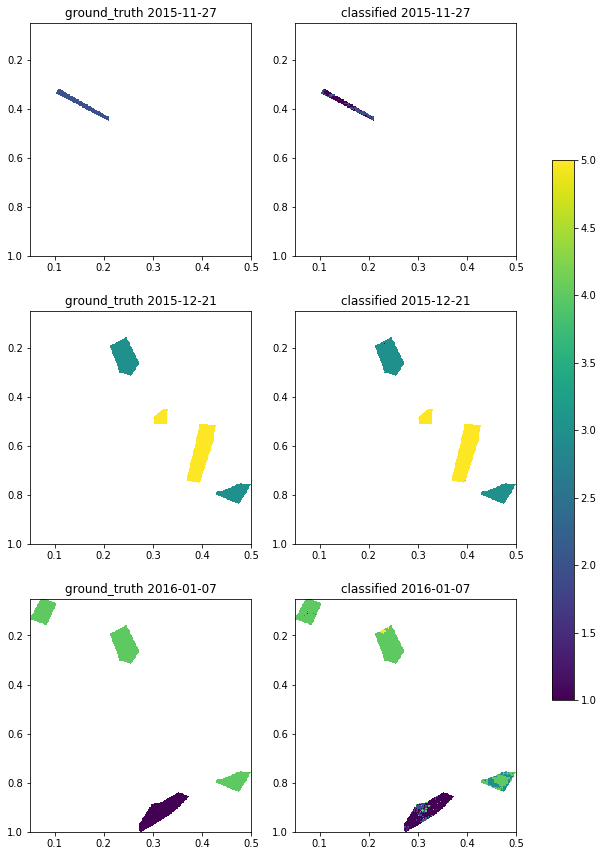

In [22]:
compare_predictions(xarr)

In [77]:
performances_idx_opt_dyn

[89.98827323365582,
 91.37469314885071,
 87.83529813770716,
 88.48448687350835,
 83.22595230021477,
 93.8780287955051,
 96.10668301655426,
 95.77383694150161,
 91.3253364540667]

## Evaluate PCA for number of features reduction

In [63]:
from h2o.transforms.decomposition import H2OPCA

pca_decomp = H2OPCA(k=5, transform="Normalize", pca_method="Randomized")

In [85]:
pca_in = []

for band in ['VV', 'VV_ASM','VV_Contrast','VV_Dissimilarity','VV_Energy','VV_Entropy',
             'VV_GLCMCorrelation','VV_GLCMMean', 'VV_GLCMVariance', 'VV_Homogeneity']:
    for der in ['','_1der']:
        for time in ['_0','_16','_n16','_n32','_n48','_n64','_n80','_n96']:
            pca_in.append(band+time)

#pca_decomp.train(x=pca_in, training_frame=train)

In [65]:
pca = pca_decomp.predict(train)
pca

pca prediction progress: |████████████████████████████████████████████████| 100%


PC1,PC2,PC3,PC4,PC5
-0.689761,0.802824,0.552728,0.443724,0.583944
0.708632,0.436599,0.981662,-0.0978511,0.306588
0.418011,0.338275,0.659393,-0.145665,0.244776
0.885644,0.639863,-0.585567,0.0489467,0.400723
0.940557,0.94801,-0.211738,0.0912162,0.144138
0.941079,0.730361,-0.494833,0.1335,0.247753
0.857098,0.643208,-0.531565,0.0960422,0.300967
0.901296,0.659432,-0.49995,0.0166188,0.311604
0.58629,0.732859,-0.144946,-0.671958,0.158541
0.416676,0.701205,-0.158334,-0.70054,0.196546


In [68]:
pca_train = train.cbind(pca)

In [67]:
pca_x = ['PC1','PC2','PC3','PC4','PC5']

for band in ['NDVI','LSWI','VV']:
    for der in ['','_1der']:
        for time in ['_0','_16','_n16','_n32','_n48','_n64','_n80','_n96']:
            pca_x.append(band+time)

print(pca_x)

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'NDVI_0', 'NDVI_16', 'NDVI_n16', 'NDVI_n32', 'NDVI_n48', 'NDVI_n64', 'NDVI_n80', 'NDVI_n96', 'NDVI_0', 'NDVI_16', 'NDVI_n16', 'NDVI_n32', 'NDVI_n48', 'NDVI_n64', 'NDVI_n80', 'NDVI_n96', 'LSWI_0', 'LSWI_16', 'LSWI_n16', 'LSWI_n32', 'LSWI_n48', 'LSWI_n64', 'LSWI_n80', 'LSWI_n96', 'LSWI_0', 'LSWI_16', 'LSWI_n16', 'LSWI_n32', 'LSWI_n48', 'LSWI_n64', 'LSWI_n80', 'LSWI_n96', 'VV_0', 'VV_16', 'VV_n16', 'VV_n32', 'VV_n48', 'VV_n64', 'VV_n80', 'VV_n96', 'VV_0', 'VV_16', 'VV_n16', 'VV_n32', 'VV_n48', 'VV_n64', 'VV_n80', 'VV_n96']


In [70]:
pca_test = test.cbind(pca_decomp.predict(test))

pca prediction progress: |████████████████████████████████████████████████| 100%


## Evaluate train/test splits

As data availability is very limited, we evaluate the stability of the model results, given different configuration of the dataset splitting into train and test datasets. This split is done at polygon level to avoid using correlated pixels from the same field in both train and test dataframes. 

The results show that there is still a high variability in the models performance (~20%) in the different split configurations.

In [62]:
opt_x = []
opt_vv_x = []


for band in ['NDVI','LSWI']:
    for der in ['','_1der']:
        for time in ['_0','_16','_n16','_n32','_n48','_n64','_n80','_n96']:
            opt_x.append(band+time)

for band in ['NDVI','LSWI','VV']:
    for der in ['','_1der']:
        for time in ['_0','_16','_n16','_n32','_n48','_n64','_n80','_n96']:
            opt_vv_x.append(band+time)



In [86]:

#Only including NDVI+LSWI at time0
performances_idx_opt_stat = []
#Incld NDVI+LSWI time-series features
performances_idx_opt_dyn = []
#Incld NDVI+LSWI+VV time-series
performances_idx_opt_vv_dyn = []
#Incld NDVI+LSWI+VV+GLCM time-series
performances_idx_opt_vv_glcm_dyn = []
#Incld NDVI+LSWI+PCA time-series
performances_idx_opt_dyn_pca = []

for seed in [11,22,33,44,55,66,77,88,99]:
    
    #Read data
    data = h2o.import_file(os.environ['WIN_SVR_DATA']+'Saldana/parquet'+str(seed)+'/')
    data['vclass'] = data['vclass'].asfactor()
    #Split
    train = data[data['tt']=='train']
    test = data[data['tt']=='test']
    
    #Fit model 1
    rf_fit = H2ORandomForestEstimator(model_id='rf_fit', ntrees=200, seed=1)
    rf_fit.train(x=['NDVI_0','LSWI_0'], y=y, training_frame=train)
    perf = (rf_fit.predict(test)['predict']==test['vclass']).as_data_frame(use_pandas=True).mean()[0]*100
    performances_idx_opt_stat.append(perf)
    
    #Fit model 2
    rf_fit = H2ORandomForestEstimator(model_id='rf_fit', ntrees=200, seed=1)
    rf_fit.train(x=opt_x, y=y, training_frame=train)
    perf = (rf_fit.predict(test)['predict']==test['vclass']).as_data_frame(use_pandas=True).mean()[0]*100
    performances_idx_opt_dyn.append(perf)
    
    #Fit model 3
    rf_fit = H2ORandomForestEstimator(model_id='rf_fit', ntrees=200, seed=1)
    rf_fit.train(x=opt_vv_x, y=y, training_frame=train)
    perf = (rf_fit.predict(test)['predict']==test['vclass']).as_data_frame(use_pandas=True).mean()[0]*100
    performances_idx_opt_vv_dyn.append(perf)
    
    #Fit model 4
    rf_fit = H2ORandomForestEstimator(model_id='rf_fit', ntrees=200, seed=1)
    rf_fit.train(x=x, y=y, training_frame=train)
    perf = (rf_fit.predict(test)['predict']==test['vclass']).as_data_frame(use_pandas=True).mean()[0]*100
    performances_idx_opt_vv_glcm_dyn.append(perf)
    
    #Fit model 5
    
    pca_decomp = H2OPCA(k=5, transform="Normalize", pca_method="Randomized")
    pca_decomp.train(x=pca_in, training_frame=train)
    pca = pca_decomp.predict(train)
    pca_train = train.cbind(pca)
    pca_test = test.cbind(pca_decomp.predict(test))
    
    rf_fit = H2ORandomForestEstimator(model_id='rf_fit', ntrees=200, seed=1)
    rf_fit.train(x=pca_x, y=y, training_frame=pca_train)
    perf = (rf_fit.predict(pca_test)['predict']==pca_test['vclass']).as_data_frame(use_pandas=True).mean()[0]*100
    performances_idx_opt_dyn_pca.append(perf)
    

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
pca Model Build progress: |███████████████████████████████████████████████| 100%


/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: _train: Dataset used may contain fewer number of rows due to removal of rows with NA/missing values.  If this is not desirable, set impute_missing argument in pca call to TRUE/True/true/... depending on the client language.
  warnings.warn(w)


pca prediction progress: |████████████████████████████████████████████████| 100%
pca prediction progress: |████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |██

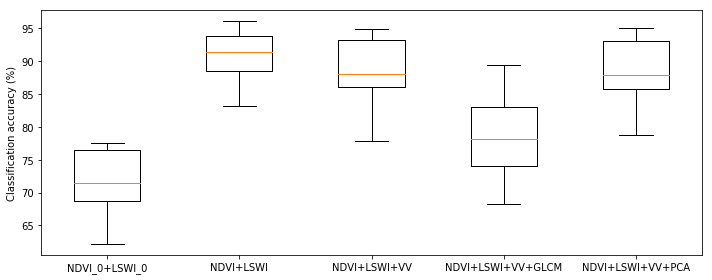

In [90]:
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.boxplot([performances_idx_opt_stat, performances_idx_opt_dyn, performances_idx_opt_vv_dyn,
            performances_idx_opt_vv_glcm_dyn, performances_idx_opt_dyn_pca])

ax1.set_xticklabels(['NDVI_0+LSWI_0','NDVI+LSWI','NDVI+LSWI+VV',
                    'NDVI+LSWI+VV+GLCM','NDVI+LSWI+VV+PCA'])

ax1.set_ylabel('Classification accuracy (%)')

plt.tight_layout()

plt.show()

## Other model configurations

In [31]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

rf_v1 = H2ORandomForestEstimator(model_id="rf_covType_v1", ntrees=500, stopping_rounds=2,
                                 score_each_iteration=True, seed=100)

rf_fit2 = H2ORandomForestEstimator(model_id='rf_fit2', ntrees=200, seed=1)

In [196]:
# Import H2O GBM:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

gbm_fit1 = H2OGradientBoostingEstimator(model_id='gbm_fit1', seed=1)
gbm_fit2 = H2OGradientBoostingEstimator(model_id='gbm_fit2', ntrees=500, seed=1)
gbm_fit3 = H2OGradientBoostingEstimator(model_id='gbm_fit3', ntrees=500, 
                                        score_tree_interval=5,     #used for early stopping
                                        stopping_rounds=3,         #used for early stopping
                                        stopping_metric='misclassification',     #used for early stopping
                                        #stopping_tolerance=0.0005, #used for early stopping
                                        seed=1)

In [161]:
# Import H2O DL <to test>
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

In [169]:
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
nb_fit1 = H2ONaiveBayesEstimator(model_id='nb_fit1')
nb_fit2 = H2ONaiveBayesEstimator(model_id='nb_fit2', laplace=6)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


In [7]:
# Close h2o cluster
h2o.cluster().shutdown(prompt=False)

H2O session _sid_abda closed.
